# Notebook 5 - Using Total Sky Imager data to pick GOES cloud thresholds

From the Friday Harbor Labs Camera data, we found thresholds using visible reflectivity (green) and infrared (red). This performed well over the San Juan Islands but struggled significantly in mountainous areas with snow and glaciers. Using the decision tree, near IR (blue) was not used because it is unnecessary for precicting cloud cover over ocean/forests. To find the needed threshold combination that will work for those scenes and correctly identify clouds from snow, we will use Total Sky Imager data from Kettle Ponds, Colorado. 

Methods:
1. Process and load TSI data
    - need to ID what spatial domain TSI is looking at to select the correct GOES pixels
2. Load in GOES data for the East River and adjacent environs for Dec-Feb (high snow cover) and Jul-Sep (low/no snow cover)
3. Run the decision tree to find thresholds
    - add depth/branches to the tree to ensure it is using near IR as well as IR and visible

In [133]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob

from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text


### Section 0 - Define time range

In [134]:
start_time = "2022-07-01"
end_time = "2022-08-31"

# Convert start_time and end_time to numpy.datetime64
start_time = np.datetime64(start_time)
end_time = np.datetime64(end_time)

### Section 1 - Process TSI data

In [135]:
tsi_ds = xr.open_dataset('/storage/cdalden/goes/surface_obs/total_sky_imager/tsi_skycover_20210901_20230616.nc')

# Select time range and filter between hour 14 and 21 UTC in one step
tsi_ds = tsi_ds.sel(
    time=tsi_ds['time'].where(
        (tsi_ds['time'] >= start_time) & 
        (tsi_ds['time'] <= end_time) & 
        (tsi_ds['time'].dt.hour >= 14)
    ).dropna('time')
)

da_percent_opaque =  tsi_ds['percent_opaque']

# Create a new cloud binary variable
tsi_ds['cloud_binary'] = xr.where(
    tsi_ds['percent_opaque'] > 75, 1,  # Cloudy: Set to 1 when > 75
    xr.where(tsi_ds['percent_opaque'] < 25, 0,  # Clear: Set to 0 when >= 0 and < 25
        np.nan  # Otherwise, set to NaN (nighttime and mixed cloud cover)
    ))

### Section 2 - Compare to GOES pixels

In [136]:
# List to store datasets
datasets = []

# Loop through all the files
for i in range(1, 32):  # Loop from 1 to 29
    # Make i two digits
    day = f"{i:02}"
    filename = f"/storage/cdalden/goes/colorado/goes16/rgb_composite/goes16_C02_C05_C13_rgb_colorado_202301{day}.nc"
    
    # Open the dataset
    dataset = xr.open_dataset(filename)
    
    # Select pixels where latitude is between 39.065 and 38.904, and longitude is between -107.08 and -106.993
    dataset = dataset.sel(
        latitude=slice(39.065, 38.904),
        longitude=slice(-107.08, -106.993)
    )
    
    # Append the spatially subsetted dataset to the list
    datasets.append(dataset)
    
    print(f"Processed file: {filename}")

# # Combine all datasets along the 'time' dimension
# combined_dataset = xr.concat(datasets, dim='t', combine_attrs='override')
# print('done with combo')

# # Save the combined dataset to a new NetCDF file
# output_filename = "/storage/cdalden/goes/colorado/goes16/rgb_composite/combined_goes16_C02_C05_C13_rgb_colorado_202301.nc"
# combined_dataset.to_netcdf(output_filename)


Processed file: /storage/cdalden/goes/colorado/goes16/rgb_composite/goes16_C02_C05_C13_rgb_colorado_20230101.nc
Processed file: /storage/cdalden/goes/colorado/goes16/rgb_composite/goes16_C02_C05_C13_rgb_colorado_20230102.nc
Processed file: /storage/cdalden/goes/colorado/goes16/rgb_composite/goes16_C02_C05_C13_rgb_colorado_20230103.nc
Processed file: /storage/cdalden/goes/colorado/goes16/rgb_composite/goes16_C02_C05_C13_rgb_colorado_20230104.nc
Processed file: /storage/cdalden/goes/colorado/goes16/rgb_composite/goes16_C02_C05_C13_rgb_colorado_20230105.nc
Processed file: /storage/cdalden/goes/colorado/goes16/rgb_composite/goes16_C02_C05_C13_rgb_colorado_20230106.nc
Processed file: /storage/cdalden/goes/colorado/goes16/rgb_composite/goes16_C02_C05_C13_rgb_colorado_20230107.nc
Processed file: /storage/cdalden/goes/colorado/goes16/rgb_composite/goes16_C02_C05_C13_rgb_colorado_20230108.nc
Processed file: /storage/cdalden/goes/colorado/goes16/rgb_composite/goes16_C02_C05_C13_rgb_colorado_2023

In [137]:
path = '/storage/cdalden/goes/colorado/goes16/rgb_composite/'
january_ds = xr.open_dataset(path + 'combined_goes16_C02_C05_C13_rgb_colorado_202301.nc')
february_ds = xr.open_dataset(path + 'combined_goes16_C02_C05_C13_rgb_colorado_202302.nc')
july_ds = xr.open_dataset(path + 'combined_goes16_C02_C05_C13_rgb_colorado_202207.nc')
august_ds = xr.open_dataset(path + 'combined_goes16_C02_C05_C13_rgb_colorado_202208.nc')

# combine july and august datasets
summer_ds = xr.concat([july_ds, august_ds], dim='t', combine_attrs='override')
winter_ds = xr.concat([january_ds, february_ds], dim='t', combine_attrs='override')


ds = summer_ds.rename({'t': 'time'})
ds

<xarray.Dataset> Size: 152MB
Dimensions:    (time: 17856, latitude: 25, longitude: 17)
Coordinates:
  * time       (time) datetime64[ns] 143kB 2022-07-01T00:02:30 ... 2022-08-31...
  * latitude   (latitude) float64 200B 39.06 39.05 39.05 ... 38.92 38.92 38.91
  * longitude  (longitude) float64 136B -107.1 -107.1 -107.1 ... -107.0 -107.0
Data variables:
    green      (time, latitude, longitude) float32 30MB 0.4671 0.4679 ... 0.0467
    blue       (time, latitude, longitude) float64 61MB 0.3345 ... 0.04175
    red        (time, latitude, longitude) float64 61MB 0.6602 0.6602 ... 0.0

In [138]:
# Compute spatial averages for red, green, and blue bands over x and y dimensions
spatial_avg = ds[['red', 'green', 'blue']].mean(dim=['latitude', 'longitude'])

# Select time range and filter between hour 14 and 21 UTC in one step
spatial_avg = spatial_avg.sel(
    time=spatial_avg['time'].where(
        (spatial_avg['time'] >= start_time) & 
        (spatial_avg['time'] <= end_time) & 
        (spatial_avg['time'].dt.hour >= 14)
    ).dropna('time')
)
# spatial_avg = spatial_avg.compute()
print('done spatial avg')

done spatial avg


### Section 3 - Align GOES and TSI data

In [139]:
# Select the nearest TSI timesteps for each spatial_avg timestep
nearest_tsi = tsi_ds['cloud_binary'].sel(time=spatial_avg['time'], method='nearest')
# Ensure no duplicate timestamps in the nearest_tsi dataset
nearest_tsi = nearest_tsi.drop_duplicates(dim='time')

In [140]:
spatial_avg['cloud_binary'] = nearest_tsi

goes_tsi_ds = spatial_avg

In [141]:
# Create a mask where all variables are non-NaN
mask = ~goes_tsi_ds.to_array().isnull().any(dim='variable')

# Apply the mask to filter the dataset
goes_tsi_ds = goes_tsi_ds.sel(time=goes_tsi_ds['time'][mask])

goes_tsi_ds

<xarray.Dataset> Size: 182kB
Dimensions:       (time: 5066)
Coordinates:
  * time          (time) datetime64[ns] 41kB 2022-07-01T14:02:30 ... 2022-08-...
Data variables:
    red           (time) float64 41kB 0.004328 0.00227 ... 0.05252 0.01994
    green         (time) float32 20kB 0.05062 0.05399 0.058 ... 0.3879 0.1016
    blue          (time) float64 41kB 0.08441 0.09442 0.1032 ... 0.5283 0.1305
    cloud_binary  (time) float64 41kB 0.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 0.0

### Section 4 - Create Decision Tree to find thresholds 

Performance Metrics:
Accuracy: 0.99
Precision: 1.00
Recall: 0.99
F1 Score: 0.99

Classification Report:
              precision    recall  f1-score   support

    No Cloud       0.99      1.00      0.99       763
       Cloud       1.00      0.99      0.99       757

    accuracy                           0.99      1520
   macro avg       0.99      0.99      0.99      1520
weighted avg       0.99      0.99      0.99      1520



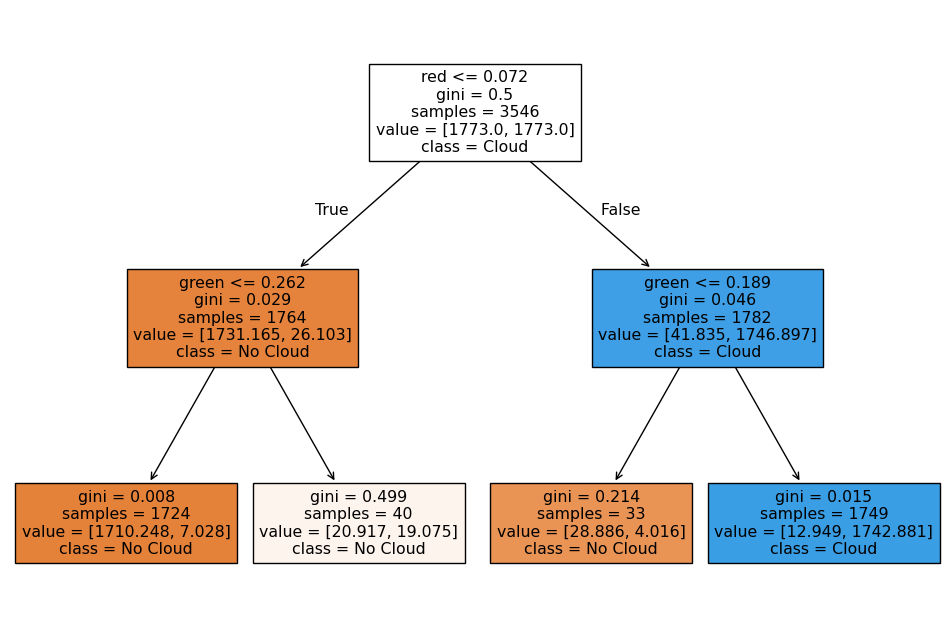

|--- red <= 0.07
|   |--- green <= 0.26
|   |   |--- class: 0.0
|   |--- green >  0.26
|   |   |--- class: 0.0
|--- red >  0.07
|   |--- green <= 0.19
|   |   |--- class: 0.0
|   |--- green >  0.19
|   |   |--- class: 1.0



In [142]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Prepare the data
X = goes_tsi_ds[['red', 'green', 'blue']].to_dataframe().dropna()
y = goes_tsi_ds['cloud_binary'].to_dataframe().loc[X.index]

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Train the decision tree classifier
clf = DecisionTreeClassifier(max_depth=2, min_samples_split=10, class_weight='balanced', random_state=42)  # Limit depth for interpretability
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

# Print the metrics
print("Performance Metrics:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Print a detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['No Cloud', 'Cloud']))

# Visualize the decision tree
plt.figure(figsize=(12, 8))
plot_tree(clf, feature_names=['red', 'green', 'blue'], class_names=['No Cloud', 'Cloud'], filled=True)
plt.show()

# Output the decision rules
tree_rules = export_text(clf, feature_names=['red', 'green', 'blue'])
print(tree_rules)

In [143]:
# Print feature importance
feature_importances = clf.feature_importances_
for feature, importance in zip(['red', 'green', 'blue'], feature_importances):
    print(f"Feature: {feature}, Importance: {importance:.4f}")

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Print the training and evaluation sample sizes
print(f"Training sample size: {len(X_train)}")
print(f"Evaluation sample size: {len(X_test)}")

Feature: red, Importance: 0.9611
Feature: green, Importance: 0.0389
Feature: blue, Importance: 0.0000
Training sample size: 3546
Evaluation sample size: 1520
